## Machine Learning Part 2-2:
### Categorical Data Startup:
#### 1: Imports pandas and the datasets, define your y or target as the SalePrice

#### 2: Drop any x values that don't have SalePrice data (rows)

#### 3: Create a list of missing columns

#### 4: Creates a candidate predictor that drops the ID and SalePrice column from the training predictor set, and drops ID from the test predictor set(why do this?)

#### 5: Define the low_cardinality_cols list as columns that have less than 10 potential values for the strings and ARE strings (dtype = object)

#### 6: Define the numeric_cols list as columns that are type int64 or float64

#### 7: Add the two lists together to create the train and test predictors that will be used

#### 8: Print a sample of the dtypes of different columns just to show which are objects (strings) and which are ints or floats. This shows us how to identify types, split data, and adjust for categorical data

In [13]:
import pandas as pd
traindata = pd.read_csv('train.csv')
testdata = pd.read_csv('test.csv') #imports and declaring datasets

traindata.dropna(axis='rows', subset=['SalePrice'], inplace=True)
target = traindata.SalePrice #drops any rows that dont have SalePrice and declare the target (y value) as the SalePrice column

cols_with_missing = []
for i in traindata.columns:
    if traindata[i].isnull().any():
        cols_with_missing.append(i)
print(cols_with_missing) #prints the list of columns that had missing values

candidate_train_predictors = traindata.drop(['Id', 'SalePrice'] + cols_with_missing, axis= 'columns')
candidate_test_predictors = testdata.drop(['Id'] + cols_with_missing, axis= 'columns') #Drop the SalePrice and Id columns from the data since it wouldn't work, as well as the columns with missing values

low_cardinality_cols = []
numeric_cols = []
for i in candidate_train_predictors.columns:
    if candidate_train_predictors[i].nunique() <10 and candidate_train_predictors[i].dtype == 'object':
        low_cardinality_cols.append(i)
    if candidate_train_predictors[i].dtype in ['int64', 'float64']:
        numeric_cols.append(i)
my_cols = low_cardinality_cols + numeric_cols #determine every low cardinality string (object) and numeric column, and add it to its respective list. Then add them together to determine every column that will be used

train_predictors = candidate_train_predictors[my_cols]
test_predictors = candidate_test_predictors[my_cols] #divide both the training and testing sets into the my_cols that will be used

print(train_predictors.dtypes.sample(10)) #print a sample of the types of 10 random columns that will be used

['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']
BsmtHalfBath     int64
OverallQual      int64
KitchenAbvGr     int64
MSSubClass       int64
PavedDrive      object
YearRemodAdd     int64
BsmtFinSF2       int64
RoofMatl        object
BsmtFullBath     int64
YearBuilt        int64
dtype: object


### Determining the effectiveness of hot encoding predictors as opposed to dropping columns
#### 9: Import cross_val_score for later calculating the MAE, as well as the model

#### 10: Use pd.get_dummies on train_predictors to hot encode columns (separate each column into every possible value as a 1 or 0, which avoids having to deal with any strings and instead makes it categorical number data, which the imputer can handle.

#### 11: Define a get_mae method that uses cross_val_score (I'm going to be honest, they just threw this at us without explaining anything) to cross validate the model multiple times, then we take the mean of these to find the MAE. Don't know why we didn't use the regular method.
http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html

#### 12: Creates a list of predictors that removes any objects (strings)

#### 13: Tests the mae of the models with and without the string predictors, with the hot encoded values performing better. This is because it accounts for whether or not the values were imputed (and therefore not actual data, subject to biases or inaccuracies)

In [41]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

one_hot_encoded_training_predictors = pd.get_dummies(train_predictors) #pd.get_dummies method to hot encode the train columns

print(one_hot_encoded_training_predictors)

def get_mae(x, y):
    return -1* cross_val_score(RandomForestRegressor(50), x, y, scoring = 'neg_mean_absolute_error').mean() #THEY DIDN'T EXPLAIN THIS AT ALL, but it essentially calculates the MAE

predictors_without_categoricals = train_predictors.select_dtypes(exclude = ['object']) #exclude string columns as a whole

mae_without_categoricals = get_mae(predictors_without_categoricals, target) #calculate the mae without the string columns

mae_one_hot_encoded = get_mae(one_hot_encoded_training_predictors, target) #calculate the mae with string columns

print('Mean Absolute Error when Dropping Categoricals: ' + str(mae_without_categoricals))
print('Mean Abslute Error with One-Hot Encoding: ' + str(mae_one_hot_encoded)) #print the MAE comparison

one_hot_encoded_test_predictors = pd.get_dummies(test_predictors) # hot encode the test columns
final_train, final_test = one_hot_encoded_training_predictors.align(one_hot_encoded_test_predictors, join='left', axis='columns')
#aligns the train and test predictors. left means it keeps columns found in training, join = 'inner' can also work (only includes columns found in both), specifying the axis as the columns.


      MSSubClass  LotArea  OverallQual  OverallCond  YearBuilt  YearRemodAdd  \
0             60     8450            7            5       2003          2003   
1             20     9600            6            8       1976          1976   
2             60    11250            7            5       2001          2002   
3             70     9550            7            5       1915          1970   
4             60    14260            8            5       2000          2000   
5             50    14115            5            5       1993          1995   
6             20    10084            8            5       2004          2005   
7             60    10382            7            6       1973          1973   
8             50     6120            7            5       1931          1950   
9            190     7420            5            6       1939          1950   
10            20    11200            5            5       1965          1965   
11            60    11924            9  

Mean Absolute Error when Dropping Categoricals: 18549.00005
Mean Abslute Error with One-Hot Encoding: 17900.4435013


### XGBoost model: A useful model that requires much tuning, but is more accurate. It is an 'ensemble' model, meaning that it uses predictions and its error to successively build more and more accurate models.
#### 14: Import the necessary nethods and packages

#### 15: Drop the columns with NaN values, declare the y value as SalePrice, and drop SalePrice from the x values

#### 16: Split the data, impute it, and train the model with it. The model performs very well,  with a relatively low error compared to random forest and especially decision trees

In [42]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer #imports necessary methods and packages

data = pd.read_csv('train.csv') #create dataframe
data.dropna(axis = 'rows', subset = ['SalePrice'], inplace = True) #drops any columns with NaN values
y = data.SalePrice #define the y value as the sale price
x = data.drop(['SalePrice'], axis = 'columns').select_dtypes(exclude = ['object']) #drop SalePrice from the x values


train_x, val_x, train_y, val_y = train_test_split(x, y, test_size = 0.25) #split into 25% test data and 75% train data
myimputer = Imputer() 
train_x = myimputer.fit_transform(train_x)
val_x = myimputer.fit_transform(val_x)#impute the missing values in both the training set and the actual values

from xgboost import XGBRegressor #import a gradient booster

mymodel = XGBRegressor()
mymodel.fit(train_x, train_y, verbose = False) #define a model, train it, and make verbose false (will not print stuff)

predictions = mymodel.predict(val_x)# create predictions from the model

from sklearn.metrics import mean_absolute_error
print("Mean Absolute Error: %s"%(mean_absolute_error(val_y, predictions)) ) #calculate the MAE from the model

Mean Absolute Error: 18555.9380137


### Putting it all together to create a better prediction:
#### 17: import the relevant method and packages

#### 18: Create the data and testdata DataFrames

#### 19: Drop any rows that don't have a SalePrice value for data, then declare the y.

#### 20: Identify columns that have empty values, add it to the list columns_with_empty, and print the sum of the NaN values for each column.

#### 21: I DID drop columns with an overwhelming amount of NaN values (over half of the column) from both the data and testdata, as I thought that they will be largely useless and imputed values will not have enough data points to make an accurate value. However, something like the quality of a pool can imply that there *is* a pool (imputation with extension), and could reasonably have an impact on the value. The submission confirmed this, so these lines were commented out.

#### 22: Drop SalePrice from the 'data' Dataframe, the 'x' values.

#### 23: Determine the columns that have a String and low cardinality or are floats or ints, adding them to the list total_cols

#### 24: Take only the total_cols from the dataset and make it the new data AND testdata.

#### 25: Adds a column_was_missing for any column in the columns_with_empty list.

#### 26: Creates 'dummy' columns for every categorical data value. 

#### 27: 'Aligns' the values for the training and test data. This uses 'inner', meaning that it will only keep columns that show up in both sets.  This avoids errors building the model.

#### 28 Splits the data into a testing and training set in order to optimize the model and prevent bias/interpolation. The split is 80% train 20% test.

#### 29: Imputes the values of the entire dataset, which returns a NumPy array. Because the array is not a DataFrame, and we need a DataFrame for other operations, we have to convert both the data and testdata sets to DataFrames by using the indices and columns that were in the original DataFrame before it was imputed.

#### 29: Goes through a large amount of n_estimator values, and the model already has other important values set such as early_stopping_rounds (how many decreases in MAE need to occur for it to automatically stop), the amount of cores that will be used to parallel process, and the learning rate (which is 1/10 of what it usually is, making a more accurate but much less efficient to process model). The for loop will determine the minimum MAE and use that in the model that will predict the actual results that will be submitted.

#### 30: Creates a new model using the results of the previous for loop, fits it to the train data(should I use the entire training set or what I used for the optimization, 80%? Test later) and predicts values based upon the testdata.

#### 31: Creates a csv submission file and prints it to the console. However, the 'Id' column was not in the form it needed to be in, so we have to use the astype() method to convert it into an int32, what it was expecting. This csv can be uploaded to Kaggle for scoring.


In [40]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor

data = pd.read_csv('train.csv')
testdata = pd.read_csv('test.csv')

data.dropna(axis = 'rows', subset = ['SalePrice'], inplace = True)
y = data.SalePrice

columns_with_empty = []
for i in data.columns:
    if data[i].isnull().any():
        columns_with_empty.append(i)
print(data[columns_with_empty].isnull().sum())

#mostlyMissing = ['Alley', 'PoolQC', 'Fence', 'MiscFeature', 'FireplaceQu']

#data = data.drop(mostlyMissing, axis = 'columns')
#testdata = testdata.drop(mostlyMissing, axis ='columns')

#columns_with_empty = list(set(columns_with_empty) - set(mostlyMissing))
print(data[columns_with_empty].isnull().sum())

data = data.drop(['SalePrice'], axis = 'columns')

total_cols = []
for i in data.columns:
    if (data[i].nunique() <10 and data[i].dtype == 'object') or data[i].dtype in ['int64', 'float64']:
        total_cols.append(i)
data = data[total_cols]
testdata = testdata[total_cols]

for i in columns_with_empty:
    data[i + '_was_empty'] = data[i].isnull()
    testdata[i + 'was_empty'] = testdata[i].isnull()
    
ohetraining = pd.get_dummies(data)
ohetest = pd.get_dummies(testdata)

ohetraining, ohetest = ohetraining.align(ohetest, join = 'inner', axis = 'columns')

my_imputer = Imputer()

ohetraining2 = my_imputer.fit_transform(ohetraining)
ohetest2 = my_imputer.fit_transform(ohetest)

imputed_features_df_train = pd.DataFrame(ohetraining2, index = ohetraining.index, columns = ohetraining.columns)
imputed_features_df_test = pd.DataFrame(ohetest2, index = ohetest.index, columns = ohetest.columns)

imputed_features_df_train, imputed_features_df_test = imputed_features_df_train.align(imputed_features_df_test, join = 'inner', axis = 'columns')

#print(imputed_features_df_train.columns)
#print(imputed_features_df_test.columns)

train_x, tval_x, train_y, tval_y = train_test_split(imputed_features_df_train, y, test_size = 0.2)

#mymodel.fit(train_x, train_y, verbose = False)
#predictions = mymodel.predict(tval_x)

#print(mean_absolute_error(tval_y, predictions))

n_estimatorsL = []
for i in range(5050, 5100, 50):
    n_estimatorsL.append(i)

minNum = 9999999999999
numVal = 0

for i in n_estimatorsL:
    mymodel = XGBRegressor(learning_rate = 0.01, n_estimators = i, early_stopping_rounds = 15, n_jobs =4)
    mymodel.fit(train_x, train_y)
    predictions = mymodel.predict(tval_x)
    mae = mean_absolute_error(tval_y, predictions)
    print('At %s n_estimators, the MAE was %2f'%(i, mae))
    if mae < minNum:
        minNum = mae
        numVal = i
print('The best MAE was %2f at %s n_estimators'%(minNum, numVal))

mymodel2 = XGBRegressor(learning_rate = 0.01, n_estimators = numVal, early_stopping_rounds = 10, n_jobs =4)
mymodel2.fit(imputed_features_df_train, y)

predictions = mymodel2.predict(imputed_features_df_test)

submission = pd.DataFrame({'Id':imputed_features_df_test.Id.astype('Int32'), 'SalePrice':predictions})
submission.to_csv('submission.csv', index = False)
print(submission)
print('done')
    
#one_hot_encoded_training_predictors = pd.get_dummies(train_predictors)
#final_train, final_test = one_hot_encoded_training_predictors.align(one_hot_encoded_test_predictors, join='left', axis='columns')

#Your Best Entry 
#You advanced 1,667 places on the leaderboard from 3599 to 1932!
#Your submission scored 0.13723, which is an improvement of your previous score of 0.19069. Great job!
#Your Best Entry 
#You advanced 12 places on the leaderboard 1932 to 1920!
#Your submission scored 0.13687, which is an improvement of your previous score of 0.13723. Great job!
    





        



LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64
LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64
At 5050 n_estimators, the MAE was 16769.475746
The best MAE was 16769.475746 at 5050 n_estimators
        Id      SalePrice
0     1461  120632.703125
1     1462  167893.500000


### Partial Dependence Plots: Examining the effect of a single variable on model predictions for insight
#### 1: Import the necessary methods and libraries

#### 2: Create the DataFrame, define the y, and print the columns of the DataFrame to see what features can be tested

#### 3: The features that will be tested are the year the house was built and the area of the lot the house is on.  The data is imputed and turned back into a DataFrame.

#### 4: The model is created, fit, and then splotted with the grid_resolution representing how many points are used to create the graph. As you can see, the price increases (in general) as the house becomes 'newer' or the area of the lot it is on expands. This makes sense, and implies that there is no leakage (for these variables)

### Unsure how to connect this with XGB instead of sklearn (ValueError: gbrt has to be an instance of BaseGradientBoosting)

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

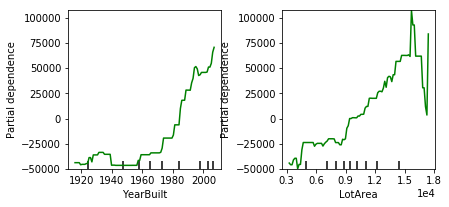

In [51]:
%matplotlib inline
import pandas as pd
#import xgboost
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence
from sklearn.preprocessing import Imputer
data2 = pd.read_csv('train.csv')
y = data2.SalePrice

print(data2.columns)

cols_to_use = ['YearBuilt', 'LotArea']

my_imputer = Imputer()
data2 = data2[cols_to_use]
x = my_imputer.fit_transform(data2)
x = pd.DataFrame(x, data2.index, data2.columns)

mymodel = GradientBoostingRegressor()
mymodel.fit(x,y)
my_plots = plot_partial_dependence(mymodel, features = [0,1], X=x, feature_names = cols_to_use, grid_resolution = 100)



### Pipelines: A compact alternative to preprocessing and training
#### 1: imports, etc

#### 2: We do some basic preprocessing of dropping rows and columns we don't need/want, making x and y variables, and splitting them. 

#### 3: We then create the pipeline, adding an imputer and defining parameters of the XGBRegressor inside the creation of the pipeline by referring to the variable the pipeline creates called xgbregressor. 

#### 4: Fit the pipeline and print out the MAE!

### Creating a pipeline like this reduces data leakage from imputing values before a split. Later, we can also include other transformers that will do things like OneHotEncode for us. Also, it may be that we can't actually edit the values of the XGBRegreessor like that, so I will have to figure that out in the future.


In [66]:
import pandas as pd
from sklearn.preprocessing import Imputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
data = pd.read_csv('train.csv')
data.dropna(axis = 'rows', subset = ['SalePrice'], inplace = True)
y = data.SalePrice
x = data.drop(['SalePrice'], axis = 'columns').select_dtypes(exclude = ['object'])

train_x, val_x, train_y, val_y = train_test_split(x, y)

from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Imputer
my_pipeline = make_pipeline(Imputer(), XGBRegressor(xgbregressor__learning_rate = 0.01, xgbregressor_n_estimators = 5000, xgbregressor__verbose= False))
my_pipeline.fit(train_x, train_y)

predictions = my_pipeline.predict(val_x)

print(mean_absolute_error(val_y, predictions))




15342.0729987


### Cross Validation: Using multiple models across a dataset to provide more accurate predictions
#### 1: Import packages and drop any rows from train data that don't have SalePrice data

#### 2: Declare the y value for training and drop SalePrice

#### 3: Go through every column and keep ones that are numbers or low cardinality strings (we don't want a million different options)

#### 4: Add extension columns to show which values will be imputed

#### 5: Hot encode the string columns to remove string data and make it categorical

#### 6: Align the data and testdata to ensure that there are no extraneous columns

#### 7: Create the pipeline and use cross validation (with 5 models running at once here, cv=5) to determine the MAE of this model.

#### 8: Train the model and submit the predictions!


In [93]:
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Imputer
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

data = pd.read_csv('train.csv')
testdata = pd.read_csv('test.csv')
data.dropna(axis = 'rows', subset = ['SalePrice'], inplace = True)
y = data.SalePrice
data = data.drop(['SalePrice'], axis = 'columns')

total_cols = []
for i in data.columns:
    if (data[i].nunique() <10 and data[i].dtype == 'object') or data[i].dtype in ['int64', 'float64']:
        total_cols.append(i)
print(total_cols)
data = data[total_cols]
testdata = testdata[total_cols]

for i in columns_with_empty:
    data[i + '_was_empty'] = data[i].isnull()
    testdata[i + 'was_empty'] = testdata[i].isnull()



data = pd.get_dummies(data)
testdata = pd.get_dummies(testdata)

data, testdata = data.align(testdata, join = 'inner', axis = 'columns')

x = data

my_pipeline = make_pipeline(Imputer(), XGBRegressor(xgbregressor_learning_rate = 0.01, xgbregressor_n_estimators = 5050, xbgregressor_n_jobs = -1, xgbregressor_verbose = False))

from sklearn.model_selection import cross_val_score
scores = cross_val_score(my_pipeline, x, y, scoring='neg_mean_absolute_error', n_jobs = -1, cv = 5)
print(sum(scores)/5)

my_pipeline.fit(data, y)

predictions = my_pipeline.predict(testdata)
submission = pd.DataFrame({'Id':testdata.Id.astype('Int32'), 'SalePrice':predictions})
submission.to_csv('submission.csv', index = False)
print('done')




['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'Fence', 'MiscFeature', 'MiscVal', 'MoSold',

# Hooray! We are now done with the Kaggle Machine Learning course!